# Comparison of Face Detection Algorithms

## Objective
In this first part of the third assignment, you will test different face detection algorithms as made available in Python through OpenCV, DLib or other Deep Learning packages.
Since a dataset (Caltech) with ground truth bounding box coordinates has been made available, you can evaluate the output of the detectors through some overlap measures.

## Guidelines and code support
You can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info and (more importantly) code snippets for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods. 

When using the [Download Code link](https://bigvisionllc.leadpages.net/leadbox/143948b73f72a2%3A173c9390c346dc/5649050225344512/) on that page, you will be downloading the Python/C++ code for all the tutorials. You just need to (re-)use the FaceDetectionComparison subdirectory for the relevant code.

As far as I can tell, the face detector in the very concise [face_recognition package](https://face-recognition.readthedocs.io/en/latest/index.html) comes in 2 flavours: HOG and MMOD. This package is developed by Adam Geitgey on top of the DLib library developed by Davis King. It has a very convenient interface to face detection and recognition modules (see later) and can thus be substituted for the Dlib based code parts. 

## Understand the methods
Please study the relevant publications on these detectors to understand their functioning. 

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1). 

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

* For the face_recognition package some info (for the face recognition part at least) can be found [here](https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78).

You can summarize the methods inside the notebook if you wish. 



## Implement and Validate
Apply these 4 techniques to the CALTECH Faces Dataset. You can re-use code made available by the packages listed previously. 

Show some results (e.g. a la the run-all.py module) to appreciate qualitively. 

You can then quantitatively evaluate the results by comparing the returned locations to the ground truth locations and validate the algorithms as such. 

Think about ways to measure the detection results. 

Guidelines (and python code) can be found in: 
* [the face detection comparison tutorial](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/), more specifically (section 5) the issues of using a reasonable overlap measure (AP_50). 
* [general object detection validation - Cartucho](https://github.com/Cartucho/mAP)
* [general object detection validation - Padilla](https://github.com/rafaelpadilla/Object-Detection-Metrics)
* [mean Average Precision - Hui](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173)
* [mean Average Precision - Arlen](https://medium.com/@timothycarlen/understanding-the-map-evaluation-metric-for-object-detection-a07fe6962cf3)

#### Importing Required Python  packages

In [0]:
# sklearn packagees
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

# varia
import numpy as np
import cv2
import dlib
from pathlib import Path

import matplotlib.pyplot as plt
# the following package contains some handy routines for image manipulation
# they have been developed by Adrian Rosenbrock
# simply install this package in your environment using "conda install imutils"
# see https://www.pyimagesearch.com/opencv-tutorials-resources-guides/ for further info
import imutils
from imutils import face_utils

from pathlib import Path
from scipy import io
import scipy
import os
from collections import namedtuple
import glob


In [0]:
# For COLAB
from google.colab import drive
drive.mount('/content/drive')
# drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# For COLAB
%cd drive/My\ Drive/Colab\ Notebooks/Biometrics
# pwd

/content/drive/My Drive/Colab Notebooks/Biometrics


In [0]:
from localmodules.datasets import load_faces

# For COLAB
caltechDataset = Path("./CalTechFacesDirs")
caltechDatasetDir = "./CalTechFacesDirs/"

# max number of persons to extract from database
max_persons = 10

faces = load_faces("CALTECH", dataset = caltechDataset, min_faces=10, max_targets=max_persons)


#### Print data statistics

In [0]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w = faces.images.shape

# for machine learning we use the flattened data
X = faces.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = faces.target
# encode the labels to integers
le = LabelEncoder()
y = le.fit_transform(y)
n_classes = np.unique(y).shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 98
n_features: 2914
n_classes: 6


## To test different face detection algorithms 

### Haar Cascade Classifiers using OpenCV
- a special case of ensemble learning, called boosting
- Viola–Jones object detection framework includes: (1)Haar Feature Selection (features derived from Haar wavelets), (2)integral image (an intermediate representation for the image), (3)Adaboost Training, (4)Cascading Classifiers.

In [0]:
# Declaring Cascade classifiers
# Detecting faces in CALTECH Dataset
font = cv2.FONT_HERSHEY_SIMPLEX

# For COLAB
cascPath  = "./haarcascade_frontalface_default.xml"
# eyePath = "./haarcascade_eye.xml"
# smilePath = "./haarcascade_smile.xml"

faceCascade = cv2.CascadeClassifier(cascPath)
# eyeCascade = cv2.CascadeClassifier(eyePath)
# smileCascade = cv2.CascadeClassifier(smilePath)


def haar_detector(gray_img):
    dets = faceCascade.detectMultiScale3(gray_img, outputRejectLevels = True)
    faces = dets[0]
    neighbours = dets[1]
    weights = dets[2]
    boxes = []
    
    for (x, y, w, h) in faces:
      x1 = x
      y1 = y
      x2 = x + w
      y2 = y + h
      face_detect = cv2.rectangle(gray_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
      roi_gray = gray_img[y1:y2, x1:x2]
      score = weights[0][0]
      frect = [score,x1,y1,x2,y2]
      boxes.append(frect)
    
    return boxes


### Histogram of Oriented Gradients (HOG) in Dlib
The idea behind HOG is to extract features into a vector and feed it into a classification algorithm like SVM. The features extracted are the distribution (histograms) of directions of gradients (oriented gradients) of the image.

In [0]:
def hog_detector(gray_img):
    frect = []
    boxes = []
    hog_face_detect = dlib.get_frontal_face_detector()
    rects, scores, index = hog_face_detect.run(gray_img, 1)
    for i in range(len(rects)):
            x1 = rects[i].left()
            y1 = rects[i].top()
            x2 = rects[i].right()
            y2 = rects[i].bottom()
            score = scores[i]
            frect = [score, x1, y1, x2, y2]
            boxes.append(frect)
    return boxes


### SSD Deep Learning Method
Reference: https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/#post_downloads

https://github.com/opencv/opencv/issues/12520

In [0]:

def ssd_detector(gray_img):
#   print(os.getcwd())
  
  modelFile = "./res10_300x300_ssd_iter_140000.caffemodel"
  configFile = "./deploy.prototxt"
  net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
  blob = cv2.dnn.blobFromImage(cv2.resize(gray_img, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  net.setInput(blob)
  detections = net.forward()

  boxes = []
  h = gray_img.shape[0]
  w = gray_img.shape[1]
  threshold = 0.6 # default threshold = 0.5

  for i in range(detections.shape[2]):
      score = detections[0, 0, i, 2]
#       print(score)
      if score > threshold:
          x1 = int(detections[0, 0, i, 3] * w)
          y1 = int(detections[0, 0, i, 4] * h)
          x2 = int(detections[0, 0, i, 5] * w)
          y2 = int(detections[0, 0, i, 6] * h)
          frect = [score, x1, y1, x2, y2]
          boxes.append(frect)

  return boxes

### MMOD Deep Learning Method

In [0]:
dnnFaceDetector = dlib.cnn_face_detection_model_v1("./mmod_human_face_detector.dat")

def mmod_detector(gray_img):
    boxes = []   
    mmod_face_detect = dnnFaceDetector(gray_img, 1)
    for i, rects in enumerate(mmod_face_detect):
        x1 = rects.rect.left()
        y1 = rects.rect.top()
        x2 = rects.rect.right()
        y2 = rects.rect.bottom()
        score = rects.confidence
        frect = [score, x1, y1, x2, y2]
        boxes.append(frect)        
    return boxes

## Saving information in .txt files for 
1) Ground Truth: It creates a text file for each image that contains the ground truth bounding boxes describing the locations of faces. This is needed for Evaluation of different face detetction techniques.
https://github.com/Cartucho/mAP/blob/master/main.py

2) Different methods of Face detection (Haar, Hog, Mmod, Ssd)

In [0]:
imgfiles = [] 
curr_dir = '/content/drive/My Drive/Colab Notebooks/Biometrics'
os.chdir(curr_dir)

haar_outPath = './Object-Detection-Metrics-master/detectionsHaar'
hog_outPath =  './Object-Detection-Metrics-master/detectionsHog'
mmod_outPath = './Object-Detection-Metrics-master/detectionsMmod'
ssd_outPath =  './Object-Detection-Metrics-master/detectionsSsd'
boxes = []

# # Ground Truth data extraction
# gtPath = "./Object-Detection-Metrics-master/groundtruths"
# gtImages = []
# matContent = scipy.io.loadmat(os.path.join(gtPath,'ImageData.mat'))
# gtData = matContent["SubDir_Data"].T


# Methods can be haar, hog, mmod, ssd
method = 'ssd' 
cnt = 0
issue_cnt = 0
k=0
for file in glob.glob(caltechDatasetDir + "*/*.jpg", recursive=True):
  
  imgfiles.append(file)

  # Extracting file name to create output file
  imgpath, filename = os.path.split(file)
  file_name = filename.split('.')[0]
  label = imgpath.split('/')[-1]

  # Reading the image
  img = cv2.imread(file,cv2.IMREAD_COLOR)
  imgtest1 = img.copy()
  gray_img = cv2.cvtColor(imgtest1, cv2.COLOR_BGR2GRAY)
  
#   # Writing Ground truth information from Image.mat file to txt file under GroundTruth Path
#   f = open(gtPath+'/'+file_name+'.txt', 'w') 
#   (xBL, yBL, xTL, yTL, xTR, yTR, xBR, yBR) = gtData[k].astype("int")
#   Data = namedtuple('Image', 'image xTL, yTL, xBR, yBR')
#   im = Data(image = str(file_name),  xTL = xTL, yTL = yTL, xBR = xBR, yBR = yBR )
#   gtImages.append(im)
#   f.write('face'+ ' ' + str(xTL)+ ' '+ str(yTL) + ' '+ str(xBR) + ' '+ str(yBR) ) 
#   f.close() 

  # Passing gray_img for face detection through various methods
  
  if (method == 'haar'):
    #HAAR
    haar_boxes = haar_detector(gray_img)  
    boxes.append(haar_boxes)
    outPath = haar_outPath
#     Total number of images with no faces detected: 2

  
  elif (method == 'hog'):
    #HOG
    hog_boxes = hog_detector(gray_img)  
    boxes.append(hog_boxes)
    outPath = hog_outPath
 
  elif (method == 'mmod'):
    #MMOd
    mmod_boxes = mmod_detector(gray_img)  
    boxes.append(mmod_boxes)
    outPath = mmod_outPath
  
  elif (method == 'ssd'):
    #SSD
    ssd_boxes = ssd_detector(img)  
    boxes.append(ssd_boxes)
    outPath = ssd_outPath


# Needed in case the folders for each image was used
#   os.chdir(outPath)
#   if not os.path.exists(label):
#     os.makedirs(label)
#   os.chdir(curr_dir)

  
#   f = open(outPath+'/'+str(label)+'/'+str(file_name)+'.txt', 'w')  - # to store the files i respective folders
  f = open(outPath+'/'+str(file_name)+'.txt', 'w') 
  if(len(boxes[-1])>0):
    for box in boxes[-1]:
      f.write('face' + ' ' + str(box[0])+ ' '+  str(box[1]) + ' '+  str(box[2]) + ' '+  str(box[3]) + ' '+  str(box[4])+'\n' )
  else:
    print(boxes[-1])
    print("Face couldnt be detected for image:",filename,"\n Cuurent count:",cnt)
    issue_cnt+=1
  f.close()
  cnt+=1

print("Total number of images with no faces detected:", issue_cnt)
print("DONE")


[]
Face couldnt be detected for image: image_0325.jpg 
 Cuurent count: 163
[]
Face couldnt be detected for image: image_0016.jpg 
 Cuurent count: 439
Total number of images with no faces detected: 2
DONE


## Evaluation of Different Detection methods

#### Precision-Recall
https://github.com/rafaelpadilla/Object-Detection-Metrics

The pascalvoc.py file was used from the above link to calculate the precision recall curves.

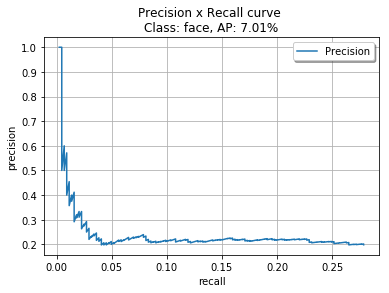

AP: 7.01% (face)
mAP: 7.01%


In [0]:
curr_dir = '/content/drive/My Drive/Colab Notebooks/Biometrics'
os.chdir(curr_dir)
%run -i "./Object-Detection-Metrics-master/pascalvoc.py" -det "detectionsHaar/"

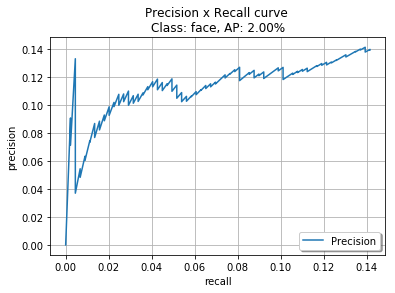

AP: 2.00% (face)
mAP: 2.00%


In [0]:
curr_dir = '/content/drive/My Drive/Colab Notebooks/Biometrics'
os.chdir(curr_dir)
%run -i "./Object-Detection-Metrics-master/pascalvoc.py" -det "detectionsHog/"

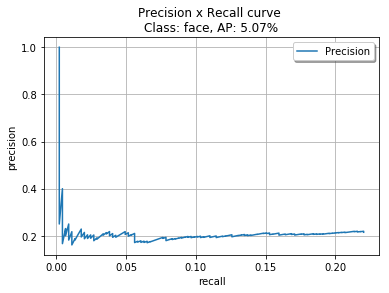

AP: 5.07% (face)
mAP: 5.07%


In [0]:
curr_dir = '/content/drive/My Drive/Colab Notebooks/Biometrics'
os.chdir(curr_dir)
%run -i "./Object-Detection-Metrics-master/pascalvoc.py" -det "detectionsMmod/"

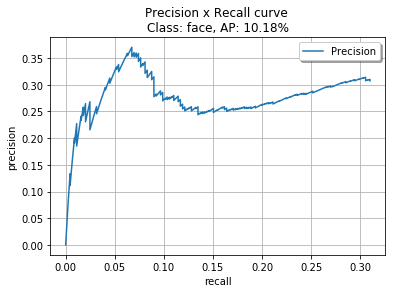

AP: 10.18% (face)
mAP: 10.18%


In [0]:
curr_dir = '/content/drive/My Drive/Colab Notebooks/Biometrics'
os.chdir(curr_dir)
%run -i "./Object-Detection-Metrics-master/pascalvoc.py" -det "detectionsSsd/"

## Conclusion
From the above Precision-Recall curves, we conclude that SSD method is superior compared to other face detection methods. Here the precision value keeps increasing along with the recall which is the ideal scenario. However, by changing the confidence threshold we get different results.